<div style="background-color:#BFBEBE; text-align: center;">
<img src="imgs/icon.png" style="width:600px">
</div>


The first step is to import libraries for audio analysis. Numpy, Scipy, and Matplotlib are standard libraries in Python. An additional library is pydub (to convert stereo to mono) that can be installed with pip install pydub. See information on how to Install Python Packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment

**Import Audio File**

Once the required packages are imported, the audio file Drone1.wav is imported. A wav file is not a compressed storage form such as mp3 files that typically require much less (typically 5x) storage for similar audio quality.

In [2]:
#Import the .wav audio
f = 'audios/Drone1.wav'
#s = sampling (int)
#a = audio signal (numpy array)
s,a = wavfile.read(f)
print('Sampling Rate:',s)
print('Audio Shape:',np.shape(a))

Sampling Rate: 48000
Audio Shape: (387072, 2)


The sampling rate is 48 kHz and there are 2 channels with 387,072 total sample points for a total of 387072/48000 = 8.064 sec.

**Display Original Signal**

Display the magnitude of the original sound from the 2 channels (stereo). Stereo contains two audio streams that are synchronized to create surround sound in 2 dimensions.

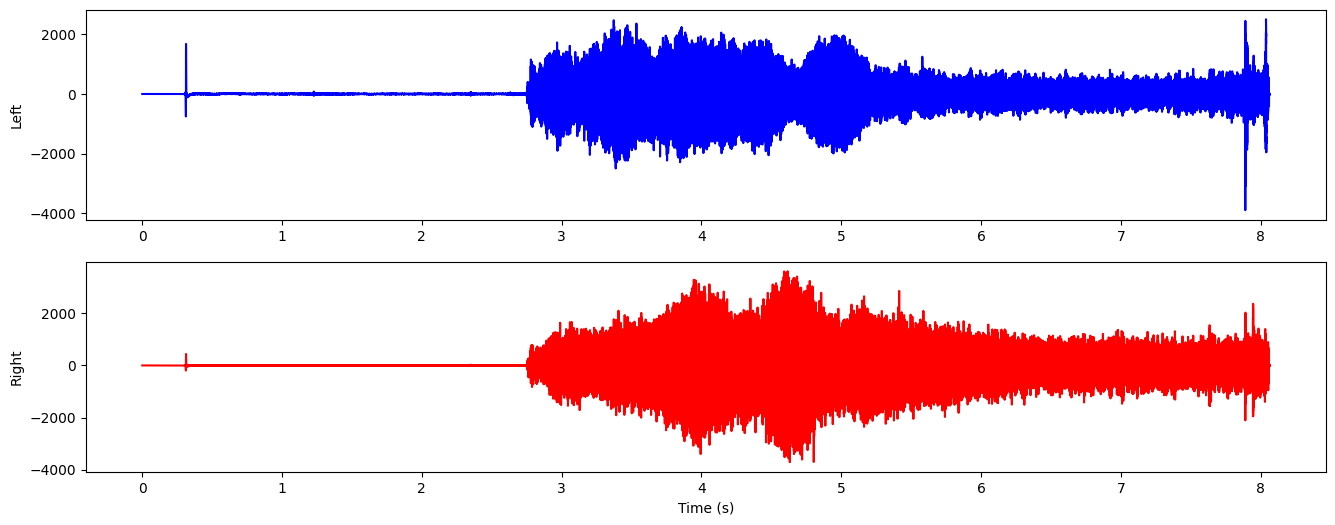

In [3]:
#number of samples
na = a.shape[0]
#audio time duration
la = na / s

#plot signal versus time
t = np.linspace(0,la,na)
plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
plt.plot(t,a[:,0],'b-')
plt.ylabel('Left')
plt.subplot(2,1,2)
plt.plot(t,a[:,1],'r-')
plt.ylabel('Right')
plt.xlabel('Time (s)')
plt.show()

**Convert to One Channel (Stereo to Mono)**

Several audio analysis packages require a single audio stream (mono) for analysis. The pydub package can be used to set the number of channels to 1 and export as a new audio file with _mono.wav appended to the end of the file name. The f[:-4] code removes the last 4 characters of the file name .wav.

In [4]:
sound = AudioSegment.from_wav(f)
sound = sound.set_channels(1)
fm = f[:-4]+'_mono.wav'
sound.export(fm, format="wav")

<_io.BufferedRandom name='audios/Drone1_mono.wav'>

**Import Audio File**

Humans can perceive sound in the range of 20 Hz to 20 kHz. Ultrasound has a frequency higher than the upper human auditory limit of 20 kHz. Common sampling rates are 44.1 kHz and 48 kHz. Higher sampling rates (88.2 kHz, 96 kHz and 192 kHz) are also common in music production. Medical ultrasound machines use waves with a frequency ranging between 2 and 15 MHz. Import the new single channel audio file with sampling rate 48 kHz.

In [5]:
s, a = wavfile.read(fm)

print('Sampling Rate:', s)
print('Audio Shape:', np.shape(a))

Sampling Rate: 48000
Audio Shape: (387072,)


**Display Modified Audio**

A single channel is now available for analysis. The audio magnitude grows as the drone is turned on and begins flying nearby.

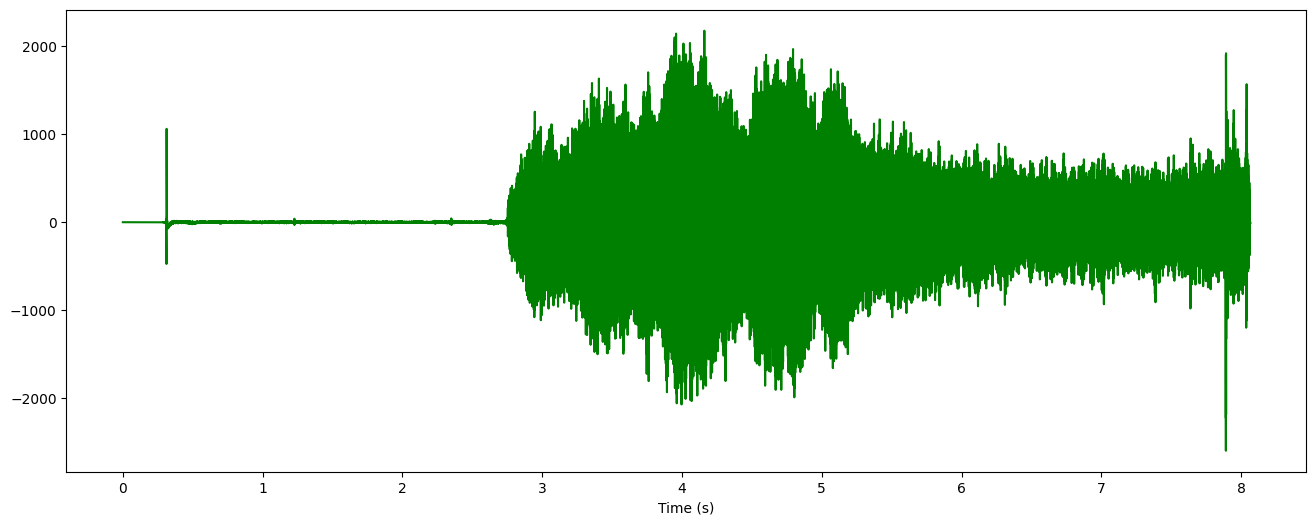

In [6]:
na = a.shape[0]
la = na / s
t = np.linspace(0, la, na)
plt.figure(figsize=(16,6))
# plt.plot(t, a, 'k-', color='purple')
plt.plot(t, a, 'g-')
plt.xlabel('Time (s)')
plt.show()

**Frequency Analysis**

A Fast Fourier Transform (FFT) analysis shows the frequency content of the entire 8 second audio file.

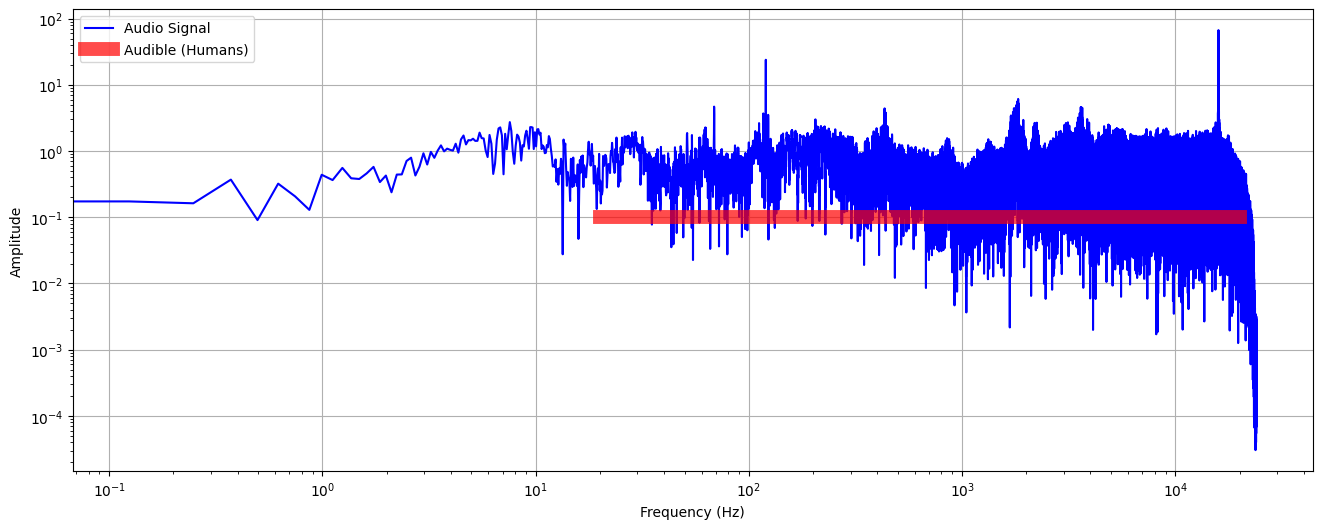

In [7]:
# analyze entire audio clip
na = len(a)
a_k = np.fft.fft(a)[0:int(na/2)]/na  # FFT function from numpy
a_k[1:] = 2*a_k[1:]  # single-sided spectrum only
Pxx = np.abs(a_k)   # remove imaginary part
f = s*np.arange((na/2))/na  # frequency vector

# plotting

fig, ax = plt.subplots(figsize=(16,6))
plt.plot(f, Pxx, 'b-', label='Audio Signal')
plt.plot([20, 20000], [0.1, 0.1], 'r-', alpha=0.7,
         linewidth=10, label='Audible (Humans)')

ax.set_xscale('log')
ax.set_yscale('log')
plt.grid()
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.show()

A segment of 48000 samples (1 sec) is analyzed for frequency content. The first second has the beep of the drone controller turning on and connecting to the drone. Otherwise, it is relatively quiet during the first second of audio.

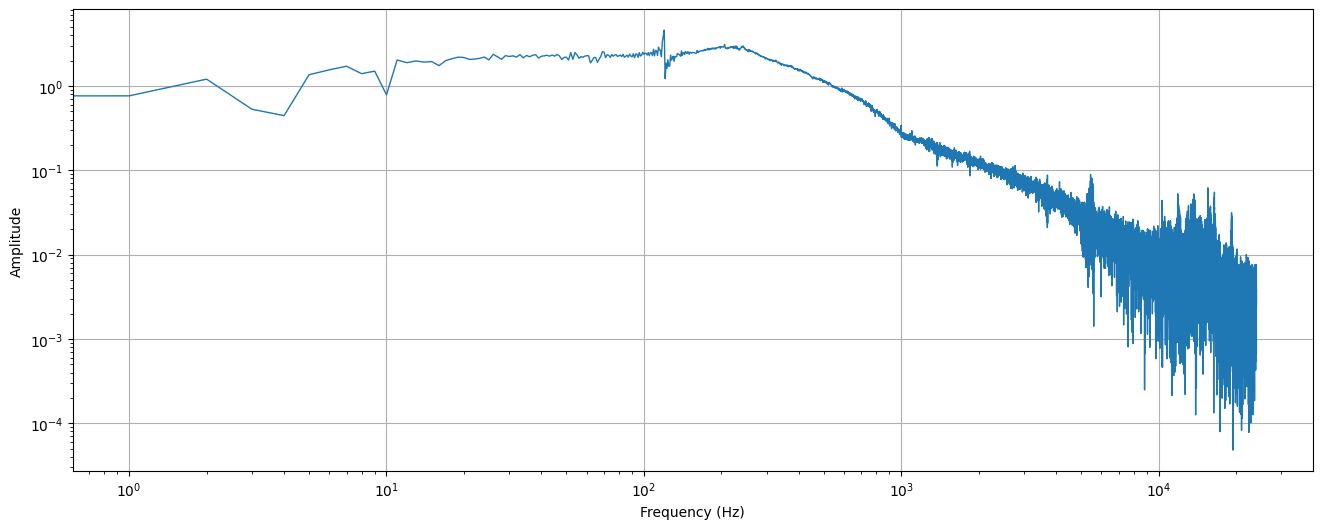

In [8]:
#first second clip
na = s
a_k = np.fft.fft(a[:na])[0:int(na/2)]/na # FFT function from numpy
a_k[1:] = 2*a_k[1:] # single-sided spectrum only
Pxx = np.abs(a_k)   # remove imaginary part
f = s*np.arange((na/2))/na # frequency vector

#plotting
fig,ax = plt.subplots(figsize=(16,6))
plt.plot(f,Pxx,linewidth=1)
ax.set_xscale('log'); ax.set_yscale('log')
plt.ylabel('Amplitude'); plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

**Spectrogram**

A spectrogram displays the frequency power at each time segment. The natural log of the spectrogram improves the visibility of the frequency content so that a few large peaks do not remove the resolution of the entire spectrogram.

/tmp/ipykernel_18325/2409296945.py:2: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


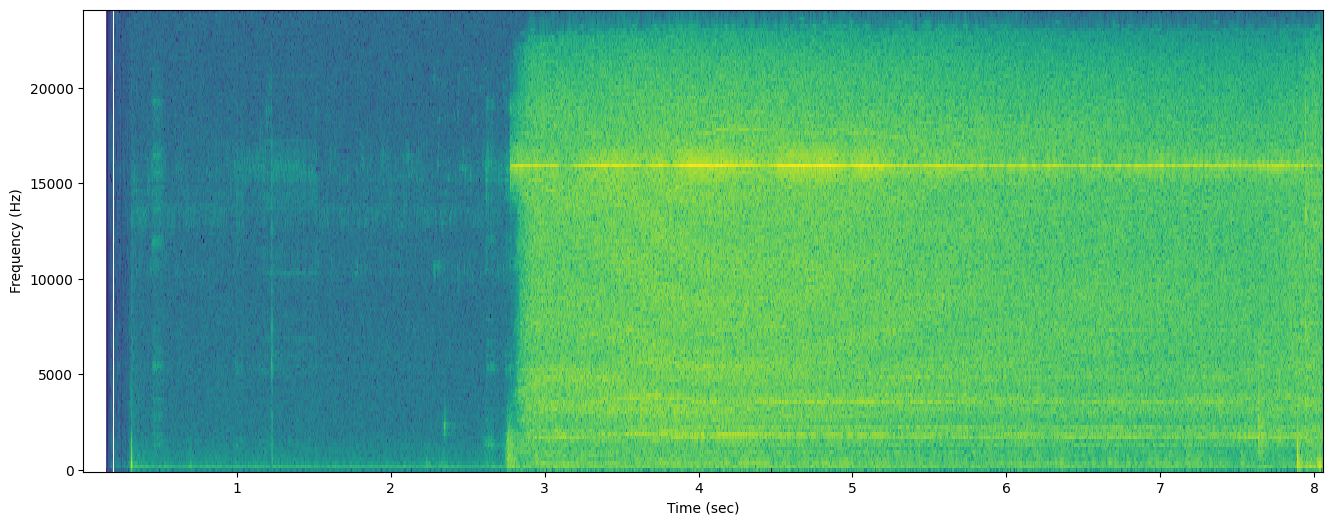

In [9]:
fr, tm, spgram = signal.spectrogram(a,s)
lspg = np.log(spgram)
plt.figure(figsize=(16,6))
plt.pcolormesh(tm,fr,lspg,shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

**Features for Machine Learning**

Now that the audio data is imported and analyzed for frequency content, it may be desireable to create features for machine learning regression or classification. All frequencies within the auditory range (20 Hz-20 kHz) may be too many.

**Bin the Frequencies**

A clustering approach uses bins to aggregate the frequency power between specified limits.

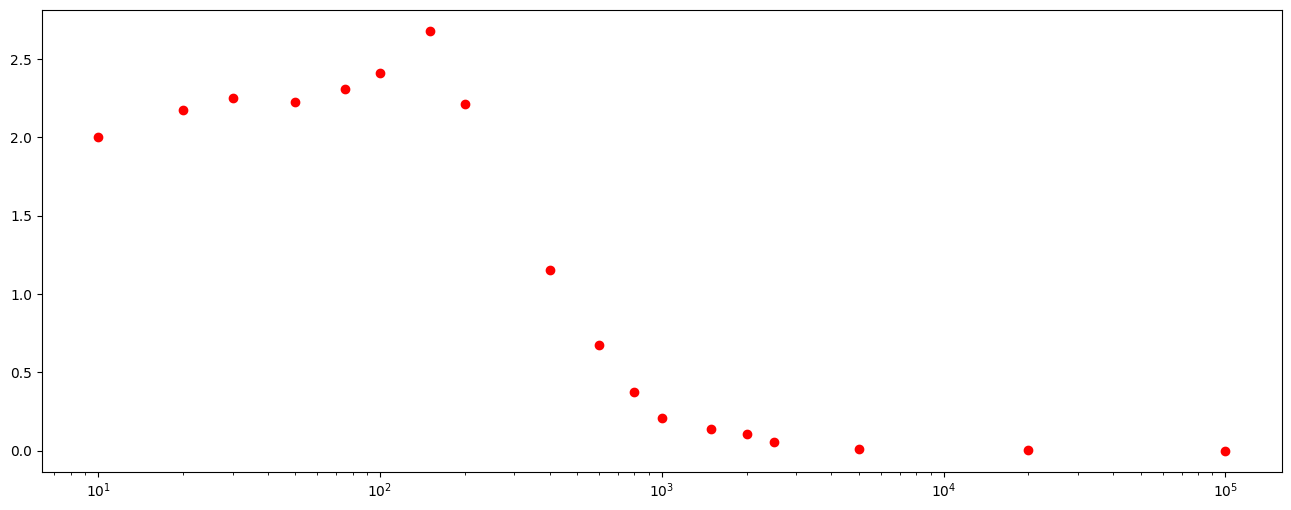

In [10]:
#bin the frequencies for machine learning features
fb = np.array([0,10,20,30,50,75,100,150,200,400,600,\
               800,1000,1500,2000,2500,5000,20000,100000])
Pb = np.zeros(len(fb))
nb = np.zeros(len(fb))
ibin = 0
n = 0
for i in range(len(f)):
    if f[i]>fb[ibin+1]:
        ibin+=1
    nb[ibin]+=1
    Pb[ibin]+=Pxx[i]
for i in range(len(fb)):
    if nb[i] == 0:
        nb[i]=1
    Pb[i] = Pb[i]/nb[i]
fig,ax = plt.subplots(figsize=(16,6))
plt.semilogx(fb,Pb,'ro',linewidth=1)
plt.show()

**Peak Frequency**

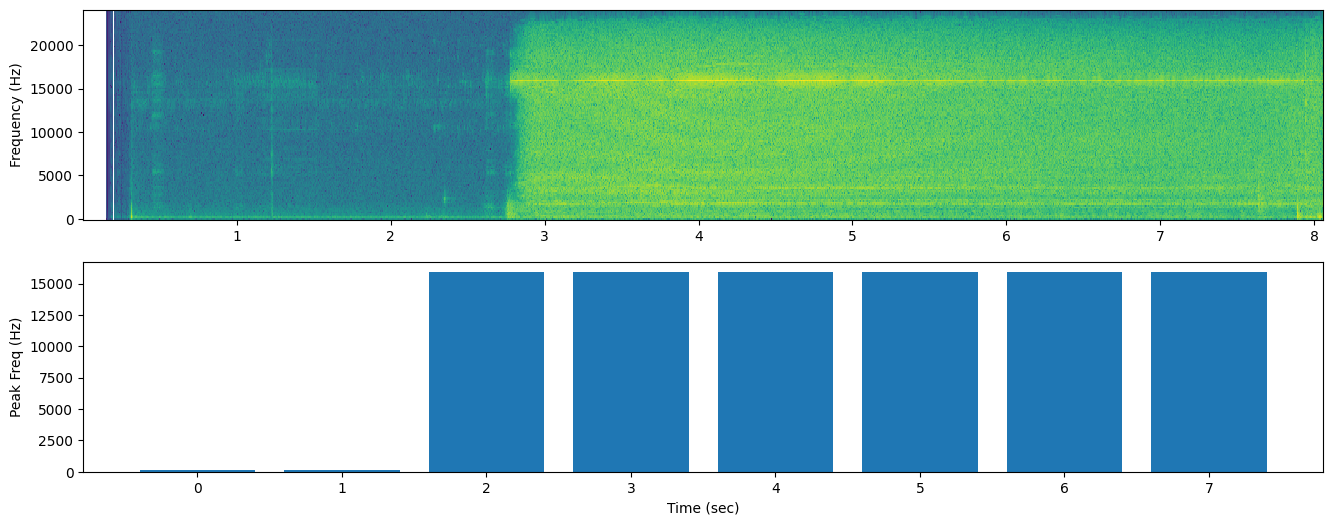

In [11]:
#analyze each sec of audio clip
nsec = int(np.floor(la))
pf = np.empty(nsec)
for i in range(nsec):
    audio = a[i*s:(i+1)*s]; na=len(audio) # use 48000 points with 48kHz
    a_k = np.fft.fft(audio)[0:int(na/2)]/na
    a_k[1:] = 2*a_k[1:]
    Pxx = np.abs(a_k)  
    f = s*np.arange((na/2))/na
    ipf = np.argmax(Pxx)
    pf[i] = f[ipf]

plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
plt.pcolormesh(tm,fr,lspg,shading='auto')
plt.ylabel('Frequency (Hz)')
plt.subplot(2,1,2)
tb = np.arange(0,nsec)
plt.bar(tb,pf)
plt.xlabel('Time (sec)'); plt.ylabel('Peak Freq (Hz)')
plt.show()

### Analysis 02

Analyze two additional audio samples to detect the presence of a drone. The first of two (Drone2.wav) is a relatively easy case where the drone takes off and lands within the audio segment. Analyze Drone2.wav by modifying the notebook and replacing Drone1.wav with Drone2.wav.

Sampling Rate: 48000
Audio Shape: (600064,)


/tmp/ipykernel_18325/2343607617.py:30: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


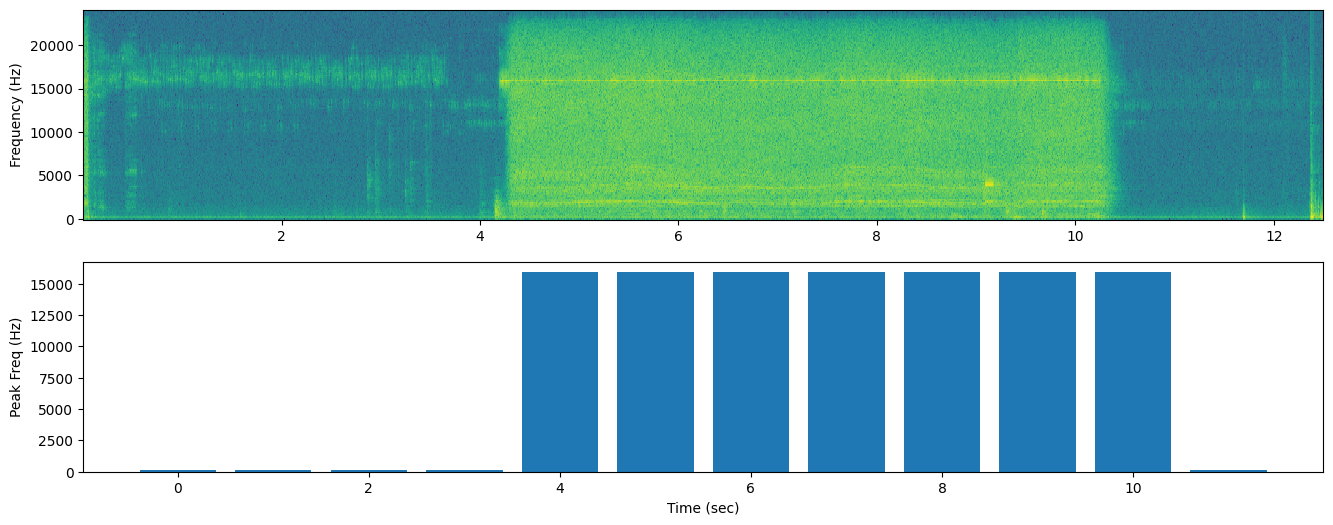

In [12]:
f = 'audios/Drone2.wav'

sound = AudioSegment.from_wav(f)
sound = sound.set_channels(1)
fm = f[:-4]+'_mono.wav'
sound.export(fm, format="wav")

s, a = wavfile.read(fm)
print('Sampling Rate:', s)
print('Audio Shape:', np.shape(a))

na = a.shape[0]
la = na / s
t = np.linspace(0, la, na)

# analyze each sec of audio clip
nsec = int(np.floor(la))
pf = np.empty(nsec)
for i in range(nsec):
    audio = a[i*s:(i+1)*s]
    na = len(audio)  # use 48000 points with 48kHz
    a_k = np.fft.fft(audio)[0:int(na/2)]/na
    a_k[1:] = 2*a_k[1:]
    Pxx = np.abs(a_k)
    f = s*np.arange((na/2))/na
    ipf = np.argmax(Pxx)
    pf[i] = f[ipf]

fr, tm, spgram = signal.spectrogram(a, s)
lspg = np.log(spgram)

plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(tm, fr, lspg, shading='auto')
plt.ylabel('Frequency (Hz)')
plt.subplot(2, 1, 2)
tb = np.arange(0, nsec)
plt.bar(tb, pf)
plt.xlabel('Time (sec)')
plt.ylabel('Peak Freq (Hz)')
# plt.savefig('drone2.png', dpi=300)
plt.show()

### Analysis 03

In the second case (Drone3.wav), the drone takes off from far away and moves closer. How could the program be modified to improve the drone detection as it approaches?

The detection program using only the peak frequency does not perform well for this case. Modify the detection algorithm to improve identification of the drone audio signature. A possible method is to analyze the power in the known frequency of the drone or build features to train and predict with a classifier.

There isn't enough data to train a classifier. A classifier typically needs a minimum of 30 samples before Machine Learning is possible and some algorithms such as Neural Networks can require many more labeled samples.

One potential solution is to isolate the signal power in the 15,000 to 16,000 Hz range. A summation of the audio power level in this region is used to create an estimate of the relative distance to the drone.

```python
pf[i] = np.sum(Pxx[np.where((f>15000)&(f<=16000))])
```

Additional data on drone position with the audio is needed to estimate an absolute distance to the drone. A cutoff distance (or audio power level) could be used to detect whether a drone is nearby.

Sampling Rate: 48000
Audio Shape: (894976,)


/tmp/ipykernel_18325/1914425835.py:31: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


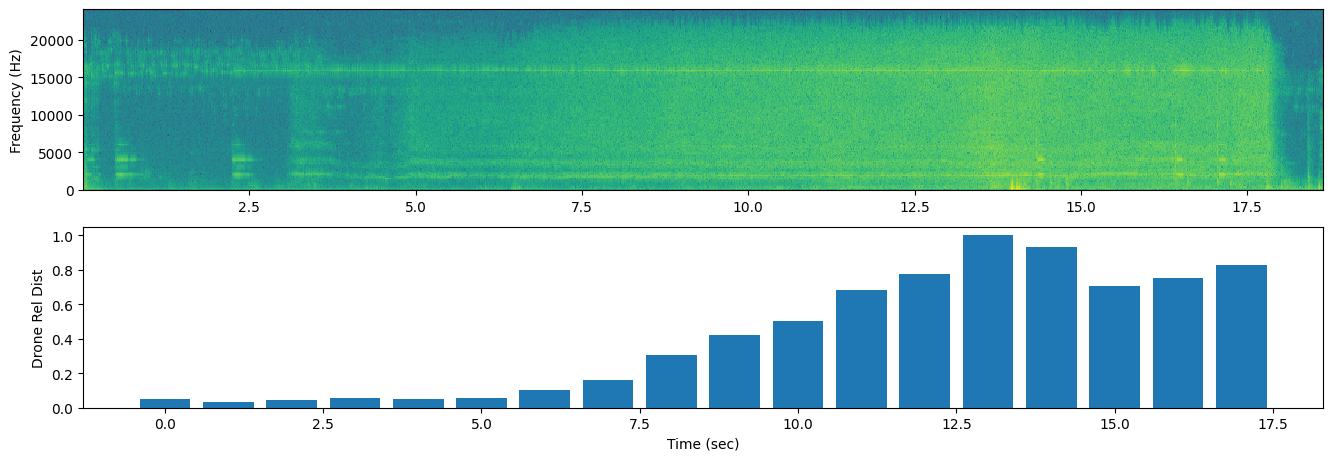

In [13]:
f = 'audios/Drone3.wav'

sound = AudioSegment.from_wav(f)
sound = sound.set_channels(1)
fm = f[:-4]+'_mono.wav'
sound.export(fm,format="wav")

s,a = wavfile.read(fm)
print('Sampling Rate:',s)
print('Audio Shape:',np.shape(a))

na = a.shape[0]
la = na / s
t = np.linspace(0,la,na)

# analyze each sec of audio clip
nsec = int(np.floor(la))
pf = np.empty(nsec)
for i in range(nsec):
    audio = a[i*s:(i+1)*s]; na=len(audio) # use 48000 points with 48kHz
    a_k = np.fft.fft(audio)[0:int(na/2)]/na
    a_k[1:] = 2*a_k[1:]
    Pxx = np.abs(a_k)  
    f = s*np.arange((na/2))/na
    pf[i] = np.sum(Pxx[np.where((f>15000)&(f<=16000))])

# normalize
pf = pf / np.max(pf)    

fr, tm, spgram = signal.spectrogram(a,s)
lspg = np.log(spgram)

plt.figure(figsize=(16,8))
plt.subplot(3,1,1)
plt.pcolormesh(tm,fr,lspg,shading='auto')
plt.ylabel('Frequency (Hz)')
plt.subplot(3,1,2)
tb = np.arange(0,nsec)
plt.bar(tb,pf)
plt.xlabel('Time (sec)'); plt.ylabel('Drone Rel Dist')
# plt.savefig('drone3.png',dpi=300)
plt.show()

[ref](https://apmonitor.com/dde/index.php/Main/AudioAnalysis)